In [ ]:
%matplotlib inline
import os
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=0

import tensorflow as tf
import glob
import os
import zarr
import random
import datetime
import numpy as np
import matplotlib.pyplot as plt
import h5py
from scipy import ndimage

from colormap import *

from unet import *

tf.executing_eagerly()

Data
-------
For the third task we are using a set of images showing epithelia cells

Two example images:
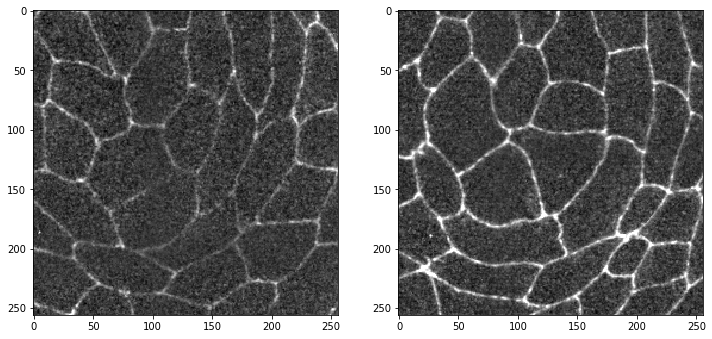

All images show epithelia tissue. There is no background in the images, only cell membrane/boundary and cell interior.
There are 24 images in the training set, 8 in the validation set and 8 in the test set.

In [ ]:
class Epithelia_dataset(tf.keras.utils.Sequence):
    """(subset of the) kaggle data science bowl 2018 dataset.
    The data is loaded from disk on the fly and in parallel using the keras Sequence class.
    This enables the use of datasets that would not fit into main memory and dynamic augmentation.
    Args:
        root_dir (string): Directory with all the images.
        kind (string): train/val/test, select subset of images
        transform (callable, optional): Optional transform to be applied
        on a sample.
    """
    def __init__(self, root_dir, data_type, batch_size, shuffle, prediction_type="two_class"):
        self.data_type = data_type
        self.files = glob.glob(os.path.join(root_dir, data_type, "*.zarr"))
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.prediction_type = prediction_type

    def __len__(self):
        return int(np.floor(len(self.files) / self.batch_size))

    def on_epoch_end(self):
        if self.shuffle == True:
            np.random.shuffle(self.files)
    
    def get_filename(self, idx):
        start_idx = min(idx * self.batch_size, len(self.files) - 1)
        end_idx = min(idx * self.batch_size + self.batch_size, len(self.files))
        return self.files[start_idx:end_idx]

    def __getitem__(self, idx):
        images = []
        labels = []
        for i in range(self.batch_size):
            fn = self.files[min(idx * self.batch_size + i, len(self.files) - 1)]
            #print(fn)
            data = zarr.open(fn)
            image = np.array(data['volumes/raw'])
            if self.prediction_type == "two_class":
                label = np.array(data['volumes/gt_fgbg'])
                label = np.logical_not(label)
                label = ndimage.binary_dilation(label, iterations=2)
                label = label.astype(np.uint8)
            elif self.prediction_type == "affinities":
                label = np.array(data['volumes/gt_affs'])
            elif self.prediction_type == "sdt":
                label = np.array(data['volumes/gt_tanh'])

            if self.data_type == "train":
                # add augmentation here, e.g.:
                # image = tf.image.random_brightness(image, 0.1)
                # be aware that some augmentations only apply to the raw data while others to both raw data and labels
                # image, label = tf.split(tf.keras.preprocessing.image.random_rotation(
                #    tf.concat([image, label], axis=0), 10, fill_mode='constant'), 2)
                # for more information see: (functions: ...random_...)
                # https://www.tensorflow.org/api_docs/python/tf/image
                # https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image?version=stable
                pass
                
            images.append(image)
            labels.append(label)
        return tf.stack(images, axis=0), tf.stack(labels, axis=0)

In [ ]:
prediction_type = "two_class" # same as fg/bg
#prediction_type = "affinities"
#prediction_type = "sdt"

if prediction_type == "two_class":    
    out_channels = 1
    activation = tf.keras.layers.Activation("sigmoid")
    loss = tf.keras.losses.BinaryCrossentropy()
    
elif prediction_type == "affinities":
    out_channels = 2
    activation = tf.keras.layers.Activation("sigmoid")
    loss = tf.keras.losses.BinaryCrossentropy()
    
elif prediction_type == "sdt":
    out_channels = 1
    activation = None
    loss = tf.keras.losses.MeanSquaredError()
    
else:
    raise RuntimeError("invalid prediction type")

Create our input datasets, ground truth labels are chosen depending on the type:

In [ ]:
data_train = Epithelia_dataset("data_epithelia", "train", 8, prediction_type=prediction_type, 
                               shuffle=True)
data_val = Epithelia_dataset("data_epithelia", "val", 8, prediction_type=prediction_type, 
                             shuffle=False)
data_test = Epithelia_dataset("data_epithelia", "test", 1, prediction_type=prediction_type, 
                              shuffle=False)

Let's have a look at some of the raw data and labels:


In [ ]:
# repeatedly execute this cell to get different images
images, labels = data_train[random.randrange(len(data_train))]
rnd = random.randrange(len(images))
image = images[rnd]
label = labels[rnd]

if prediction_type == "affinities":
    label = label[0] + label[1]

fig=plt.figure(figsize=(12, 8))
fig.add_subplot(1, 2, 1)
plt.imshow(np.squeeze(image), cmap='gray')
fig.add_subplot(1, 2, 2)
plt.imshow(np.squeeze(label), cmap='gist_earth')


Define our U-Net
==============
As before, we define our neural network architecture and can choose the depth and number of feature maps at the first convolution.



In [ ]:
# to be removed
width = 256
height = 256
net_input = tf.keras.Input(shape=(1, height, width), name='img')
net = net_input

net_output, fov = unet(net, out_channels, depth=3, num_fmaps=32, activation=activation)

net = tf.keras.Model(net_input, net_output, name='unet')

print("Receptive field of view: {}".format(fov))
net.summary()

Training
=======

Before we start training, we have to compile the network and set the optimizer (try playing with the learning rate, a higher learning rate can lead to faster training, but also to divergence or lower performance).

To visualize our results we now use Tensorboard. This is a very useful extension for your browser that let's you look network graph and the weights and metrics over time.

In [ ]:
# define optimizer, loss and validation metrics
if prediction_type == "two_class":
    net.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
            loss=loss,
            metrics=[tf.keras.metrics.Precision(thresholds=0.9), tf.keras.metrics.Recall(thresholds=0.9)]
    )
else:
    net.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                loss=loss,
               )
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
%reload_ext tensorboard
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=10)

In [ ]:
history = net.fit_generator(data_train,
                  epochs=100,
                  # We pass some validation for
                  # monitoring validation loss and metrics
                  # at the end of each epoch
                  validation_data=data_val,
                  initial_epoch=0,
                  callbacks=[tensorboard_callback])

print('Finished Training')
!ps aux | grep --color=auto tensorboard | grep --color=auto 6014 | awk '{print $2}' | xargs kill
%tensorboard --logdir $logdir --port 6014

Postprocessing
=============

In contrast to the semantic segmentation we postprocessing to extract the final segmentation is a bit more involved and consists of x steps:
- based on the prediction we define a surface
- we extract the maxima from this surface
- we use the maxima as seeds in an off-the-shelf watershed algorithm
- and mask the result with the foreground
The foreground areas covered by the watershed from each seed point correspond to the instances.
The resulting instances are then matched to the ground truth instances (at least 50% overlap) to get our final score (averaged over all instances and all test images)

In [ ]:
%reload_ext autoreload
%autoreload 2
from label import *
from evaluate import *

avg = 0.0
for idx, pred in enumerate(net.predict_generator(data_test)):
    # thresholds are 
    if prediction_type == "two_class":
        fg_thresh = 0.7
        seed_thresh = 0.8 
    elif prediction_type == "sdt":
        fg_thresh = 0.0
        seed_thresh = -0.14
    elif prediction_type == "affinities":
        fg_thresh = 0.9
        seed_thresh = 0.95

    image = np.squeeze(data_test[idx][0])
    gt_labels = np.squeeze(data_test[idx][1])
    if prediction_type == "affinities":
        gt_labels = gt_labels[0] + gt_labels[1]
    
    if prediction_type == "two_class":
        thresh = pred >= fg_thresh
        thresh = 1 - thresh
        labelling, _ = ndimage.label(thresh)
        surface = pred
    else:
        labelling, surface = label(pred, prediction_type, fg_thresh=fg_thresh, seed_thresh=seed_thresh)
        gt_labels = 1 - gt_labels
    
    ap, precision, recall, tp, fp, fn = evaluate(labelling, data_test.get_filename(idx)[0])
    avg += ap
    labelling = labelling.astype(np.uint8)

    print("average precision: {}, precision: {}, recall: {}".format(ap, precision, recall))
    print("true positives: {}, false positives: {}, false negatives: {}".format(tp, fp, fn))
    
    fig=plt.figure(figsize=(16, 8))
    ax = fig.add_subplot(1, 4, 1)
    ax.set_title("raw")
    plt.imshow(np.squeeze(image))
    ax = fig.add_subplot(1, 4, 2)
    ax.set_title("gt labels")
    plt.imshow(np.squeeze(gt_labels))
    
    ax = fig.add_subplot(1, 4, 3)
    ax.set_title("prediction")
    plt.imshow(np.squeeze(surface))
    ax = fig.add_subplot(1, 4, 4)
    ax.set_title("pred segmentation")
    plt.imshow(np.squeeze(labelling), cmap=rand_cmap)

    plt.show()
avg /= (idx+1)
print("average precision on test set: {}".format(avg))
if prediction_type == "two_class":
    results = net.evaluate_generator(data_test)
    print("boundary precision: {}, recall: {}".format(results[1], results[2]))